In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from scipy import  stats
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import tushare as ts

In [2]:
dta = ts.get_k_data('sh',start='2017-01-03',end='2017-12-25')['close']
# dta=np.array(dta,dtype=np.float)
len(dta)

240

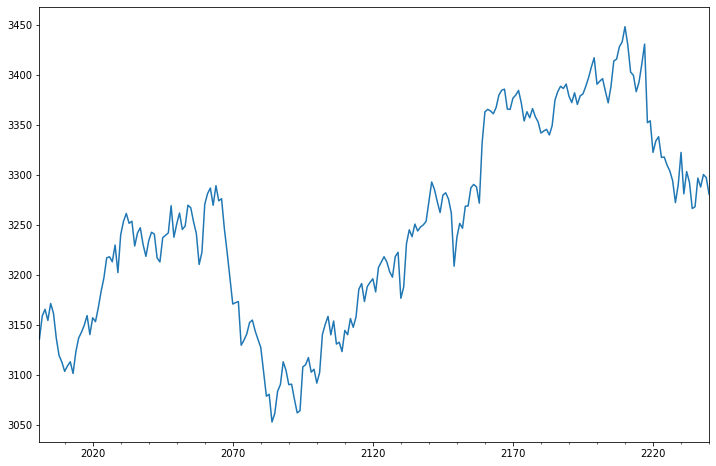

In [3]:
dta=pd.Series(dta)
dta.index = pd.Index(sm.tsa.datetools.dates_from_range('2001','2240'))
dta.plot(figsize=(12,8))
plt.show()

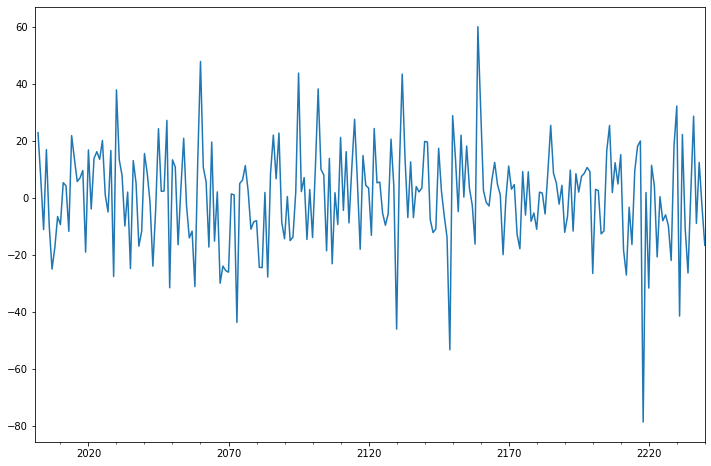

In [4]:
fig = plt.figure(figsize=(12,8))
ax1= fig.add_subplot(111)
diff1 = dta.diff(1)
diff1.plot(ax=ax1)

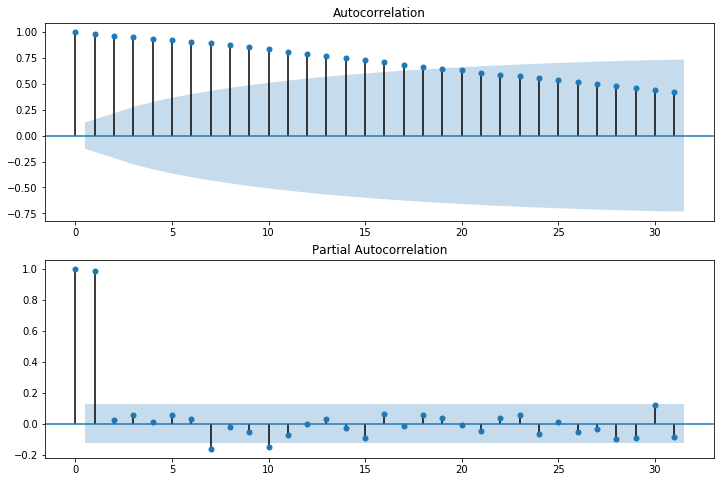

In [5]:
diff1= dta.diff(1)
fig = plt.figure(figsize=(12,8))
ax1=fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta,lags=31,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta,lags=31,ax=ax2)

In [6]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 移动平均图
def draw_trend(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    rol_weighted_mean = pd.DataFrame.ewm(timeSeries, span=size).mean()

    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()
    
def draw_ts(timeSeries):
    f = plt.figure(facecolor='white')
    timeSeries.plot(color='blue')
    plt.show()

def testStationarity(ts):
    dftest = adfuller(ts)
    print(dftest)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

# 自相关和偏相关图，默认阶数为31阶
def draw_acf_pacf(ts, lags=31):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts, lags=31, ax=ax1)
    ax2 = f.add_subplot(212)
    plot_pacf(ts, lags=31, ax=ax2)
    plt.show()

In [7]:
testStationarity(diff1[1:])
# testStationarity(dta)

(-15.512524009409871, 2.338642174163747e-28, 0, 238, {'1%': -3.458128284586202, '5%': -2.873761835239286, '10%': -2.5732834559706235}, 1920.5705977744115)


Test Statistic                -1.551252e+01
p-value                        2.338642e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.380000e+02
Critical Value (1%)           -3.458128e+00
Critical Value (5%)           -2.873762e+00
Critical Value (10%)          -2.573283e+00
dtype: float64

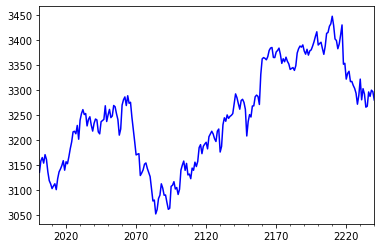

In [8]:
draw_ts(dta)

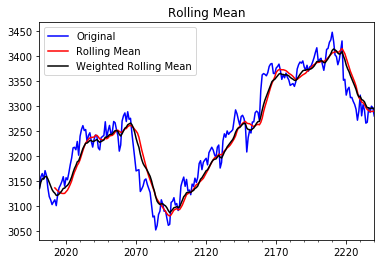

In [9]:
draw_trend(dta, 12)

In [10]:
ts_log = np.log(dta)
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
testStationarity(ts_diff_1)

(-2.493559019661485, 0.11704936069610128, 12, 215, {'1%': -3.461136478222043, '5%': -2.875078880098608, '10%': -2.5739861168199027}, -2561.502060680678)


Test Statistic                  -2.493559
p-value                          0.117049
#Lags Used                      12.000000
Number of Observations Used    215.000000
Critical Value (1%)             -3.461136
Critical Value (5%)             -2.875079
Critical Value (10%)            -2.573986
dtype: float64

In [11]:
from statsmodels.tsa.arima_model import ARMA
model = ARMA(ts_diff_1, order=(1, 1)) 
result_arma = model.fit( disp=-1, method='css')

c:\users\junming\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency A-DEC will be used.
  % freq, ValueWarning)


In [12]:
predict_ts = result_arma.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)
log_recover.dropna(inplace=True)

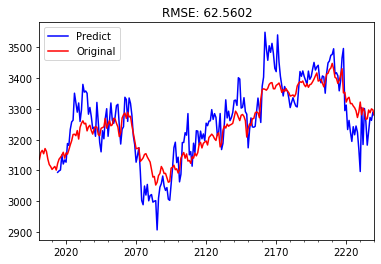

In [13]:
# ts = ts[log_recover.index]  # 过滤没有预测的记录
plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
dta.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((np.array(log_recover)-np.array(dta[13:]))**2)/dta.size))
plt.show()